# Applied Machine Learning

This notebook compiles standard methods for classification and regression into one notebook. The hope is that this notebook will be a good template to begin projects and reduce repetitive work.

![xkcd](https://imgs.xkcd.com/comics/machine_learning.png)

https://xkcd.com/1838/

## Dependencies

In [387]:
# installations
%pip install lightgbm
%pip install xgboost

In [329]:
# standard DS / ML libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [330]:
# data viz
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
# make sure viz shows up in the notebook
%matplotlib inline
import seaborn as sns

In [331]:
# regression
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC

In [332]:
# classification
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

In [333]:
# model performance & iterative improvement
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import roc_curve, precision_recall_curve,  roc_auc_score, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from time import perf_counter

## Set Up

In [334]:
class BaseDataset:
  """
  Basic methods to handle loading and splitting data for experiments
  """

  def _load_data(self):
    """
    _load_data is a method that expects to be overwritten by the class extension
    :return: error, if not implemented in the extended class
    """
    raise NotImplementedError

  def split_data_and_label(self, train_data, label_column_name, id_column_name=None):
    """
    split_data_and_label takes a training set and returns data split from labels

    :param train_data: a training set without labels
    :param train_label: a set of labels detached from training data
    :return: train, validate, and test data
    """
    if id_column_name is not None:
      del train_data[id_column_name]
    
    train_label = train_data[label_column_name]
    del train_data[label_column_name]
    
    return train_data, train_label   

  def _split_data(self, train_data, train_label, sampling_method):
    """
    shuffle_split exploits the behavior of sklearn's train test split to split the data into train, validate, test in a standard 80 / 10 / 10 pattern

    :param train_data: a training set without labels
    :param train_label: a set of labels detached from training data
    :return: train, validate, and test data
    """ 


  def _subsample(self, train_data, train_label, number_of_samples):
    """
    stratified_split divides data into train / validate / test while maintaining the percentages of each class

    :param train_data: a training set without labels
    :param train_label: a set of labels detached from training data
    :return: train, validate, and test data
    """ 
    rs = np.random.RandomState(42)
    indices0 = rs.choice(np.where(train_label == 0)[0], number_of_samples, replace=False)
    indices1 = rs.choice(np.where(train_label == 1)[0], number_of_samples, replace=False)
    indices = np.concatenate([indices0, indices1])
    train_data = train_data.iloc[indices]
    train_label = train_label.iloc[indices]
    # train_data = train_data.reset_index(inplace=True)
    # train_label = train_label.reset_index(inplace=True)
    return train_data, train_label
    
  

  def get_train_val_test_data(self, train_data, train_label, values_to_stratify_by=None):
    """
    get_train_val_test_data exploits the behavior of sklearn's train test split to split the data into train, validate, test in a standard 80 / 10 / 10 pattern

    :param train_data: a training set without labels
    :param train_label: a set of labels detached from training data
    :return: train, validate, and test data
    """ 

    X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(
        train_data, train_label, test_size=0.2, random_state=42, shuffle=True, stratify=values_to_stratify_by)
    X_val, X_test, y_val, y_test = train_test_split(
        X_test_and_val, y_test_and_val, test_size=0.5, random_state=42, shuffle=True, stratify=values_to_stratify_by)
    
    return dict(X_train=X_train, y_train=y_train,
                X_val=X_val, y_val=y_val,
                X_test=X_test, y_test=y_test)
    

  def nan_check(self, data):
    """
    nan_check is a method that reports missing data by percentage

    :param data: a dataframe containing training data
    :return: a dataframe containing a report of missing data
    """ 

    total = data.isnull().sum().sort_values(ascending=False)
    percent_1 = data.isnull().sum()/data.isnull().count()*100
    percent_2 = (np.round(percent_1, 1)).sort_values(ascending=False)
    missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
    return missing_data

## Data

In [335]:
class ExperimentDataset(BaseDataset):
  
  def _load_data(self, filepath):
    """
    _load_data gets data from source, then lower cases all column names

    :param filepath: path where the data is located
    :return: train, validate, and test data
    """ 
    df = pd.read_csv(filepath)
    df = df.rename(columns=str.lower)
    return df

dataset = ExperimentDataset()
training_label = 'training_label_column_name'

In [336]:
# https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data?resource=download
eda_data = dataset._load_data('./penguins_size.csv')

In [337]:
eda_data.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


## Exploratory Data Analysis

In [338]:
eda_data.shape

(344, 7)

In [339]:
eda_data.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


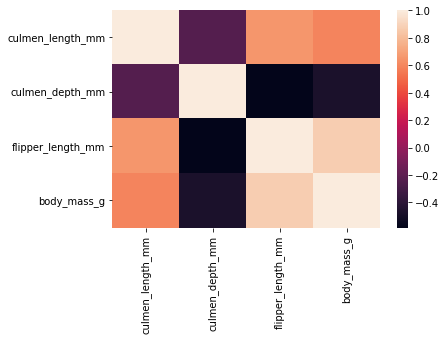

In [340]:
corr = eda_data.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

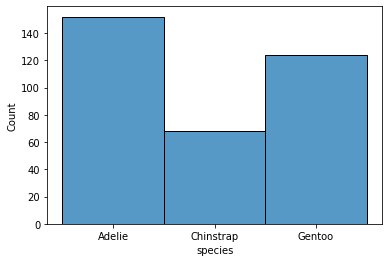

In [341]:
sns.histplot(data=eda_data, x="species")

In [342]:
# profile = ProfileReport(eda_data)
# profile.to_widgets()

## Data Cleaning && Feature Engineering

In [343]:
eda_data.info

<bound method DataFrame.info of     species     island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
0    Adelie  Torgersen              39.1             18.7              181.0   
1    Adelie  Torgersen              39.5             17.4              186.0   
2    Adelie  Torgersen              40.3             18.0              195.0   
3    Adelie  Torgersen               NaN              NaN                NaN   
4    Adelie  Torgersen              36.7             19.3              193.0   
..      ...        ...               ...              ...                ...   
339  Gentoo     Biscoe               NaN              NaN                NaN   
340  Gentoo     Biscoe              46.8             14.3              215.0   
341  Gentoo     Biscoe              50.4             15.7              222.0   
342  Gentoo     Biscoe              45.2             14.8              212.0   
343  Gentoo     Biscoe              49.9             16.1              213.0   

     bo

In [344]:
binned_label = 'species'
continuous_label = 'body_mass_g'
data = eda_data

In [345]:
column_list = list(data.columns)
column_list_without_label = column_list.remove(binned_label)
numeric_column_names = data.select_dtypes(include=np.number).columns.tolist()
categorical_column_names = data.select_dtypes(exclude=np.number).columns.tolist()

In [346]:
categorical_column_names.remove(binned_label)

### Handle Outliers

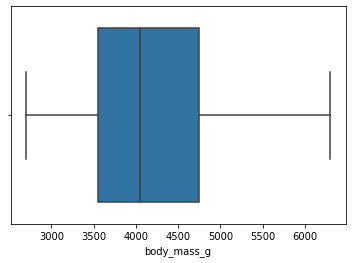

In [347]:
ax = sns.boxplot(x=data[continuous_label])

#### Visualize Outliers

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

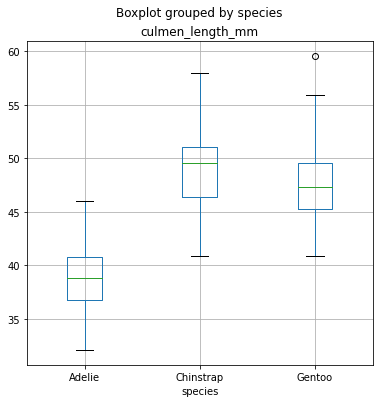

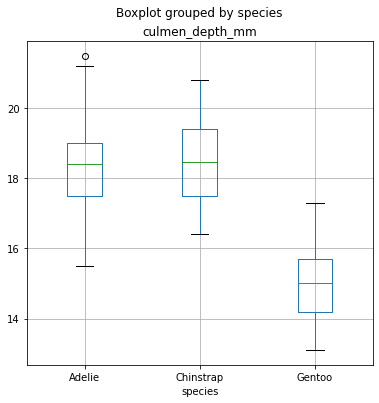

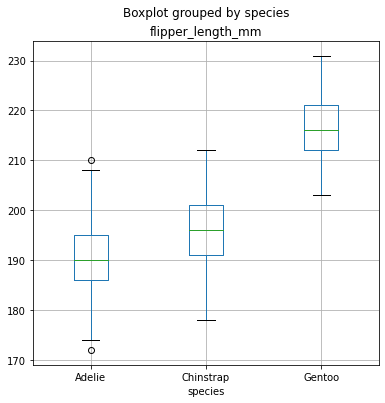

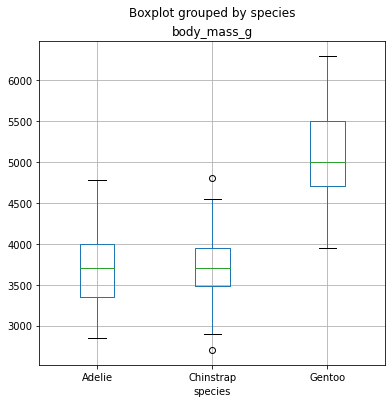

In [348]:
for col in numeric_column_names:
    data.boxplot(column=col, by=binned_label, figsize=(6,6))
    plt.title(col)
plt.show()

#### By Standard Deviation

In [349]:
# Dropping the outlier rows with standard deviation above a factor
factor = 2
upper_lim = data[continuous_label].mean () + data[continuous_label].std () * factor
lower_lim = data[continuous_label].mean () - data[continuous_label].std () * factor

data = data[(data[continuous_label] < upper_lim) & (data[continuous_label] > lower_lim)]

#### By Percentile

In [350]:
#Dropping the outlier rows with Percentiles

# upper_lim = data['column'].quantile(.95)
# lower_lim = data['column'].quantile(.05)

# data = data[(data['column'] < upper_lim) & (data['column'] > lower_lim)]

#### Check Outliers After Data Transformation

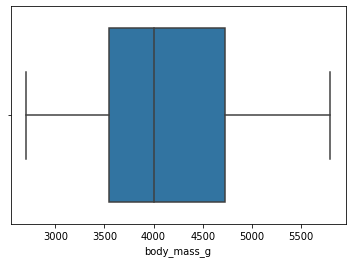

In [351]:
ax = sns.boxplot(x=data[continuous_label])

### Binning

 #### Numerical

In [352]:
# data['bin'] = pd.cut(data['value'], bins=[0,30,70,100], labels=["Low", "Mid", "High"])

#### Categorical

In [353]:
# conditions = [
#     data['Country'].str.contains('Spain'),
#     data['Country'].str.contains('Italy'),
#     data['Country'].str.contains('Chile'),
#     data['Country'].str.contains('Brazil')]

# choices = ['Europe', 'Europe', 'South America', 'South America']

# data['Continent'] = np.select(conditions, choices, default='Other')

### Imputation / Handling Missing Values

In [354]:
dataset.nan_check(data)

,Total,%
sex,8,2.4
species,0,0.0
island,0,0.0
culmen_length_mm,0,0.0
culmen_depth_mm,0,0.0
flipper_length_mm,0,0.0
body_mass_g,0,0.0


#### Drop Option

##### Above Threshold

In [355]:
# threshold = 0.7
#Dropping columns with missing value rate higher than threshold
# data = data[data.columns[data.isnull().mean() < threshold]]

#Dropping rows with missing value rate higher than threshold
# data = data.loc[data.isnull().mean(axis=1) < threshold]

##### All Nulls

In [356]:
data = data.dropna()

#### Fill Option

##### Numeric: Fill with Zero

In [357]:
# filling all missing values with 0
# data = data.fillna(0)

##### Numeric: Fill with Median

In [358]:
# filling missing values with medians of the columns
# data = data.fillna(data.median())

String: Fill with Categorical Most Common Value

#### Check Missing Values Again After Data Transformation

In [359]:
dataset.nan_check(data)

,Total,%
species,0,0.0
island,0,0.0
culmen_length_mm,0,0.0
culmen_depth_mm,0,0.0
flipper_length_mm,0,0.0
body_mass_g,0,0.0
sex,0,0.0


### One-Hot Encoding

In [360]:
one_hotted_columns = pd.get_dummies(data[categorical_column_names])

data = data.drop(columns=categorical_column_names)

data = pd.concat([data, one_hotted_columns], axis=1)

data

,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_.,sex_FEMALE,sex_MALE
0,Adelie,39.1,18.7,181.0,3750.0,0,0,1,0,0,1
1,Adelie,39.5,17.4,186.0,3800.0,0,0,1,0,1,0
2,Adelie,40.3,18.0,195.0,3250.0,0,0,1,0,1,0
4,Adelie,36.7,19.3,193.0,3450.0,0,0,1,0,1,0
5,Adelie,39.3,20.6,190.0,3650.0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
338,Gentoo,47.2,13.7,214.0,4925.0,1,0,0,0,1,0
340,Gentoo,46.8,14.3,215.0,4850.0,1,0,0,0,1,0
341,Gentoo,50.4,15.7,222.0,5750.0,1,0,0,0,0,1
342,Gentoo,45.2,14.8,212.0,5200.0,1,0,0,0,1,0


#### Check Column List After One Hot Encoding Categorical Data

In [361]:
data.columns

Index(['species', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
       'body_mass_g', 'island_Biscoe', 'island_Dream', 'island_Torgersen',
       'sex_.', 'sex_FEMALE', 'sex_MALE'],
      dtype='object')

In [362]:
data.head()

,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_.,sex_FEMALE,sex_MALE
0,Adelie,39.1,18.7,181.0,3750.0,0,0,1,0,0,1
1,Adelie,39.5,17.4,186.0,3800.0,0,0,1,0,1,0
2,Adelie,40.3,18.0,195.0,3250.0,0,0,1,0,1,0
4,Adelie,36.7,19.3,193.0,3450.0,0,0,1,0,1,0
5,Adelie,39.3,20.6,190.0,3650.0,0,0,1,0,0,1


### Splitting

##### Strings

In [363]:
# data.full_name
#Extracting first names
# data.full_name.str.split(" ").map(lambda x: x[0])
#Extracting last names
# data.full_name.str.split(" ").map(lambda x: x[-1])

##### Numbers

In [364]:
# find a method that splits at the decimal or rounds

### Other String Cleaning Methods (e.g. regex)

### Scaling

##### Normalization of a Single Column

In [365]:
# data['normalized_label'] = (data[continuous_label] - data[continuous_label].min()) / (data[continuous_label].max() - data[continuous_label].min())

##### Standardization of a Single Column

In [366]:
# data['standardized_label'] = (data[continuous_label] - data[continuous_label].mean()) / data[continuous_label].std()

##### Pipelines

Normally scaling is done in the context of a pipeline. This can be combined with training to streamline. Here's an example below for reference.

In [367]:
# # https://scikit-learn.org/stable/modules/preprocessing.html
# # https://www.kaggle.com/code/satishgunjal/binary-multiclass-classification-using-sklearn/notebook#Multiclass-Classification

# # Define preprocessing for numeric columns (scale them)
# feature_columns = [0,1,2,3]
# feature_transformer = Pipeline(steps=[
#     ('scaler', StandardScaler())
#     ])

# # Create preprocessing steps
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('preprocess', feature_transformer, feature_columns)])

# # Create training pipeline
# pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                            ('regressor', SVC(probability=True))])


# # fit the pipeline to train a linear regression model on the training set
# multi_model = pipeline.fit(x_penguin_train, y_penguin_train)
# print (multi_model)

### Date Handling

In [368]:
# #Transform string to date
# data['date'] = pd.to_datetime(data.date, format="%d-%m-%Y")

# #Extracting Year
# data['year'] = data['date'].dt.year

# #Extracting Month
# data['month'] = data['date'].dt.month

# #Extracting passed years since the date
# data['passed_years'] = date.today().year - data['date'].dt.year

# #Extracting passed months since the date
# data['passed_months'] = (date.today().year - data['date'].dt.year) * 12 + date.today().month - data['date'].dt.month

# #Extracting the weekday name of the date
# data['day_name'] = data['date'].dt.day_name()

### PII & IDs

In [369]:
# TO DO:

### Drop Columns as Needed

In [370]:
columns_to_drop = ['sex_.']

data = data.drop(columns=columns_to_drop)

### Sanity Check Before Train Test Split

In [371]:
data.columns

Index(['species', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
       'body_mass_g', 'island_Biscoe', 'island_Dream', 'island_Torgersen',
       'sex_FEMALE', 'sex_MALE'],
      dtype='object')

In [372]:
data.head()

,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_FEMALE,sex_MALE
0,Adelie,39.1,18.7,181.0,3750.0,0,0,1,0,1
1,Adelie,39.5,17.4,186.0,3800.0,0,0,1,1,0
2,Adelie,40.3,18.0,195.0,3250.0,0,0,1,1,0
4,Adelie,36.7,19.3,193.0,3450.0,0,0,1,1,0
5,Adelie,39.3,20.6,190.0,3650.0,0,0,1,0,1


## Split Data into Training, Validation, and Test Sets

In [373]:
train_data, train_label = dataset.split_data_and_label(data, binned_label)

In [374]:
train_data

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_FEMALE,sex_MALE
0,39.1,18.7,181.0,3750.0,0,0,1,0,1
1,39.5,17.4,186.0,3800.0,0,0,1,1,0
2,40.3,18.0,195.0,3250.0,0,0,1,1,0
4,36.7,19.3,193.0,3450.0,0,0,1,1,0
5,39.3,20.6,190.0,3650.0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...
338,47.2,13.7,214.0,4925.0,1,0,0,1,0
340,46.8,14.3,215.0,4850.0,1,0,0,1,0
341,50.4,15.7,222.0,5750.0,1,0,0,0,1
342,45.2,14.8,212.0,5200.0,1,0,0,1,0


In [375]:
train_label

0      Adelie
1      Adelie
2      Adelie
4      Adelie
5      Adelie
        ...  
338    Gentoo
340    Gentoo
341    Gentoo
342    Gentoo
343    Gentoo
Name: species, Length: 325, dtype: object

In [376]:
values_to_stratify_by = eda_data.species.unique()
values_to_stratify_by

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

In [377]:
experiment_data = dataset.get_train_val_test_data(train_data, train_label)

In [378]:
X_train = experiment_data['X_train']
X_val = experiment_data['X_val']
X_test = experiment_data['X_test']
y_train = experiment_data['y_train']
y_val = experiment_data['y_val']
y_test = experiment_data['y_test']

## Experimentation

### Methods


In [379]:
class BasicModelsWithDefaults: 
  """
  Basic implementation of looping through machine learning models

  :param models: a list of scikit-learn models
  :return: a data frame that summarizes the results
  """

  def __init__(self, models, data, model_tracker, experiment_type):
    self._models = models
    self._size = len(models)
    self._data = data
    self._model_tracker = model_tracker
    self._experiment_type = experiment_type
    self._fitted_models = None


  def fit(self):
    """
    fits a list of machine learning models with default parameters

    :param models: a list of scikit-learn models
    :return: a list of fit times
    """
    fitted_models = []

    for i in range(self._size):
      fitted_i = self._models[i].fit(self._data['X_train'], self._data['y_train'])
      fitted_models.append(fitted_i)
      self._fitted_models = fitted_models # this might not work
    return
    

  def predict(self):
    """
    predicts results based a list of machine learning models

    :param models: a list of fitted_models
    :return: a list of predictions
    """
    predictions = []

    for model in self._models:
      y_pred_train = model.predict(self._data['X_train'])
      y_pred_val = model.predict(self._data['X_val'])
      # (y_true, y_pred, train_or_test, experiment_type, model_description, dataset, model_tracker)
      self._model_tracker = perf_eval.report_performance(self._data['y_train'], y_pred_train, 'train', self._experiment_type, f'Train {model}', 'X_train' , self._model_tracker)
      self._model_tracker = perf_eval.report_performance(self._data['y_val'], y_pred_val, 'validate', self._experiment_type, f'Validate {model}', 'X_val' , self._model_tracker)
    return self._model_tracker


In [380]:
class Ensemble: 
  """
  Basic implementation of an ensemble with majority vote aggregation.

  :param models: a list of scikit-learn models
  :return: an aggregation of predictions
  """

  def __init__(self, models):
    self._models = models
    self._size = len(models)

  def fit(self, X_train, y_train):
    for i in range(self._size):
      self._models[i].fit(X_train, y_train)

  def predict(self, X_test):
    preds = []
    for i in range(self._size):
      pred_i = self._models[i].predict(X_test)
      preds.append(pred_i)
    preds = np.vstack(preds)
    agg = []
    for j in range(preds.shape[1]):
      agg.append(np.bincount(preds[:, j]).argmax())
    agg = np.array(agg)
    return agg

In [381]:
class BasePerformanceEvaluation:
  
  def __init__(self):
    self._column_names = ["model_type", "train_or_test", "dataset", "accuracy", "precision", "recall", "f1_score", "confusion_matrix", "mean_squared_error", "mean_absolute_error", "mean_absolute_percentage_error"]

  def create_tracker(self):
    return pd.DataFrame(columns = self._column_names)

  def report_performance(self, y_true, y_pred, train_or_test, experiment_type, model_description, dataset, model_tracker):
    
    if experiment_type == 'regression':
      mse = mean_squared_error(y_true, y_pred)
      mae = mean_absolute_error(y_true, y_pred)
      mape = mean_absolute_percentage_error(y_true, y_pred)
      accuracy = None
      precision = None
      recall = None
      f1 = None
      confusion = NotImplementedError

    elif experiment_type == 'classification':
      accuracy = accuracy_score(y_true, y_pred)
      precision = precision_score(y_true, y_pred, average='weighted')
      recall = recall_score(y_true, y_pred, average='weighted')
      f1 = f1_score(y_true, y_pred, average='weighted')
      confusion = confusion_matrix(y_true, y_pred)
      mse = None
      mae = None
      mape = None
    
    else:
      raise NotImplementedError

    new_row = pd.DataFrame([[f'{model_description}', f'{train_or_test}', f'{dataset}', accuracy, precision, recall, f1, confusion, mse, mae, mape]], columns=self._column_names)
    model_tracker = pd.concat([model_tracker, new_row])

    return model_tracker

perf_eval = BasePerformanceEvaluation()

In [382]:
model_tracker = perf_eval.create_tracker()
model_tracker

,model_type,train_or_test,dataset,accuracy,precision,recall,f1_score,confusion_matrix,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error


### Experiments

#### Classification

Predict central tendency or most common class as a baseline for comparison.

##### Baseline

In [383]:
y_train_baseline = np.full(y_train.size, 'Adelie')
y_val_baseline = np.full(y_val.size, 'Adelie')
y_test_baseline = np.full(y_test.size, 'Adelie')

# (self, y_true, y_pred, train_or_test, experiment_type, model_description, dataset, model_tracker)
model_tracker = perf_eval.report_performance(y_train, y_train_baseline, 'train', 'classification', 'Train Majority Class', 'X_train', model_tracker)
model_tracker = perf_eval.report_performance(y_val, y_val_baseline, 'validate', 'classification', 'Validate Majority Class', 'X_val', model_tracker)
model_tracker

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model_type,train_or_test,dataset,accuracy,precision,recall,f1_score,confusion_matrix,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
0,Train Majority Class,train,X_train,0.442308,0.195636,0.442308,0.271282,"[[115, 0, 0], [55, 0, 0], [90, 0, 0]]",None,None,None
0,Validate Majority Class,validate,X_val,0.500000,0.250000,0.500000,0.333333,"[[16, 0, 0], [9, 0, 0], [7, 0, 0]]",None,None,None


##### Default Parameters

In [384]:
clf_models = [LogisticRegression(), RidgeClassifier(), KNeighborsClassifier(), SGDClassifier(), DecisionTreeClassifier(), ExtraTreeClassifier()]
clf_models_with_defaults = BasicModelsWithDefaults(clf_models, experiment_data, model_tracker, 'classification')
clf_models_with_defaults.fit()
model_tracker = clf_models_with_defaults.predict()
model_tracker

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predict

,model_type,train_or_test,dataset,accuracy,precision,recall,f1_score,confusion_matrix,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
0,Train Majority Class,train,X_train,0.442308,0.195636,0.442308,0.271282,"[[115, 0, 0], [55, 0, 0], [90, 0, 0]]",None,None,None
0,Validate Majority Class,validate,X_val,0.500000,0.250000,0.500000,0.333333,"[[16, 0, 0], [9, 0, 0], [7, 0, 0]]",None,None,None
0,Train LogisticRegression(),train,X_train,0.992308,0.992308,0.992308,0.992308,"[[114, 1, 0], [1, 54, 0], [0, 0, 90]]",None,None,None
0,Validate LogisticRegression(),validate,X_val,0.968750,0.971875,0.968750,0.969068,"[[15, 1, 0], [0, 9, 0], [0, 0, 7]]",None,None,None
0,Train RidgeClassifier(),train,X_train,0.996154,0.996223,0.996154,0.996163,"[[114, 1, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,Validate RidgeClassifier(),validate,X_val,0.968750,0.970588,0.968750,0.968304,"[[16, 0, 0], [1, 8, 0], [0, 0, 7]]",None,None,None
0,Train KNeighborsClassifier(),train,X_train,0.842308,0.846388,0.842308,0.836864,"[[104, 4, 7], [21, 32, 2], [6, 1, 83]]",None,None,None
0,Validate KNeighborsClassifier(),validate,X_val,0.812500,0.811143,0.812500,0.793452,"[[15, 1, 0], [4, 4, 1], [0, 0, 7]]",None,None,None
0,Train SGDClassifier(),train,X_train,0.346154,0.120285,0.346154,0.178532,"[[0, 0, 115], [1, 0, 54], [0, 0, 90]]",None,None,None
0,Validate SGDClassifier(),validate,X_val,0.218750,0.047852,0.218750,0.078526,"[[0, 0, 16], [0, 0, 9], [0, 0, 7]]",None,None,None


##### Bagging

In [385]:
clf_bagging_models = [RandomForestClassifier(), BaggingClassifier(base_estimator=KNeighborsClassifier()), BaggingClassifier(base_estimator=SVC()), BaggingClassifier(base_estimator=DecisionTreeClassifier()), BaggingClassifier(base_estimator=ExtraTreeClassifier())]
clf_bagging_models_with_defaults = BasicModelsWithDefaults(clf_bagging_models, experiment_data, model_tracker, 'classification')
clf_bagging_models_with_defaults.fit()
model_tracker = clf_bagging_models_with_defaults.predict()
model_tracker

,model_type,train_or_test,dataset,accuracy,precision,recall,f1_score,confusion_matrix,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
0,Train Majority Class,train,X_train,0.442308,0.195636,0.442308,0.271282,"[[115, 0, 0], [55, 0, 0], [90, 0, 0]]",None,None,None
0,Validate Majority Class,validate,X_val,0.500000,0.250000,0.500000,0.333333,"[[16, 0, 0], [9, 0, 0], [7, 0, 0]]",None,None,None
0,Train LogisticRegression(),train,X_train,0.992308,0.992308,0.992308,0.992308,"[[114, 1, 0], [1, 54, 0], [0, 0, 90]]",None,None,None
0,Validate LogisticRegression(),validate,X_val,0.968750,0.971875,0.968750,0.969068,"[[15, 1, 0], [0, 9, 0], [0, 0, 7]]",None,None,None
0,Train RidgeClassifier(),train,X_train,0.996154,0.996223,0.996154,0.996163,"[[114, 1, 0], [0, 55, 0], [0, 0, 90]]",None,None,None
0,Validate RidgeClassifier(),validate,X_val,0.968750,0.970588,0.968750,0.968304,"[[16, 0, 0], [1, 8, 0], [0, 0, 7]]",None,None,None
0,Train KNeighborsClassifier(),train,X_train,0.842308,0.846388,0.842308,0.836864,"[[104, 4, 7], [21, 32, 2], [6, 1, 83]]",None,None,None
0,Validate KNeighborsClassifier(),validate,X_val,0.812500,0.811143,0.812500,0.793452,"[[15, 1, 0], [4, 4, 1], [0, 0, 7]]",None,None,None
0,Train SGDClassifier(),train,X_train,0.346154,0.120285,0.346154,0.178532,"[[0, 0, 115], [1, 0, 54], [0, 0, 90]]",None,None,None
0,Validate SGDClassifier(),validate,X_val,0.218750,0.047852,0.218750,0.078526,"[[0, 0, 16], [0, 0, 9], [0, 0, 7]]",None,None,None


##### Boosting

In [ ]:
clf_boosting_models = [GradientBoostingClassifier(), LGBMClassifier()]
clf_boosting_models_with_defaults = BasicModelsWithDefaults(clf_boosting_models, experiment_data, model_tracker, 'classification')
clf_boosting_models_with_defaults.fit()
model_tracker = clf_boosting_models_with_defaults.predict()
model_tracker

##### Ensembling

##### Neural Nets

##### Feature Ablation

##### Hyperparamater Optimization

#### Regression

##### Default Parameters

##### Bagging


##### Boosting

##### Ensembling

##### Neural Nets

##### Feature Ablation

##### Hyperparamater Optimization

## Results

### Data

In [386]:
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

NameError: ignored

### Visualization

#### Classification

In [ ]:
# binary 

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
# precision recall curve
precision, recall, _ = precision_recall_curve(y_val, best_model.decision_function(X_val))
plt.plot(recall, precision, 'b-')
precision, recall, _ = precision_recall_curve(y_val, baseline_model.decision_function(X_val))
plt.plot(recall, precision, 'r-')
plt.title("Logistic Regression Precision-Recall curve")
plt.show()

#### Regression

In [ ]:
precision, recall, _ = precision_recall_curve(y_val, baseline_model.decision_function(X_val))
plt.plot(recall, precision, 'b-')
precision, recall, _ = precision_recall_curve(y_val, best_model.decision_function(X_val))
plt.plot(recall, precision, 'r-')
plt.title("Precision-Recall curve")
plt.show()

## Discussion

### Best current model

In [ ]:
model_tracker.sort_values(by="accuracy", ascending=False)

### Error Analysis

### Recommendations for Future Work

## Research Journal

### Data-Centric Iteration Ideas


### Model-Centric Iteration Ideas

### Improvements to the Template

- training time tracking
- distinguish between binary and multi-class classification

### Daily Log